# Automatic mesh refinement in layered structures

This tutorial demonstrates how to use `LayerRefinementSpec` to automatically refine mesh in layered structures in `Tidy3D`. Those layered structures are commonly found in devices fabricated with printed circuit boards. This tool can identify geometric corners on the layer cross-section, and automatically refine and snap the grids around these critical points. It can also automatically adjust mesh density along the layer thickness direction. This capability is especially valuable for improving simulation accuracy and convergence in cases involving metallic structures, where electromagnetic fields can change dramatically near metal interfaces and even exhibit singular behavior at corners. For background on meshing in FDTD, we recommend first reviewing our [automatic nonuniform meshing](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/AutoGrid.html) tutorial.

To demonstrate the key features of `LayerRefinementSpec`, we'll walk through a practical example on a simple patch antenna structure.

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials.

In [1]:
# basic imports
import pprint

import matplotlib.pylab as plt
import numpy as np

# tidy3d imports
import tidy3d as td

Simple rectangular patch antenna but with a cutout in the top.

In [2]:
mm = 1e3  # millimeters

# patch antenna dimensions
patch_length = 30 * mm
patch_width = 30 * mm
patch_thickness = 0.02 * mm

# transmission line dimensions
transmission_width = 2 * mm
transmission_length = 90 * mm

# slot dimensions
slot_width = 5 * mm
slot_length = 3 * mm

# cutout dimensions
cutout_radius = 10 * mm

# substrate dimensions
sub_length = 50 * mm
sub_width = 50 * mm
sub_thickness = 1 * mm

Let's define the geometry of the patch antenna consisting of a patch, a substrate, and a ground plane.

In [3]:
# define patch geometry
patch_geometry_original = td.Box(
    center=(0, 0, 0),
    size=(patch_width, patch_length, patch_thickness),
)

tranmission_line_geometry = td.Box(
    center=(0, -transmission_length / 2, 0),
    size=(transmission_width, transmission_length, patch_thickness),
)

slot_geometry = td.Box(
    center=(0, -patch_length / 2 + slot_length / 2, 0),
    size=(slot_width, slot_length, patch_thickness),
)

cutout_geometry = td.Cylinder(
    center=(0, patch_length / 2, 0),
    axis=2,
    radius=cutout_radius,
    length=patch_thickness,
)

patch_geometry = (
    patch_geometry_original - slot_geometry + tranmission_line_geometry - cutout_geometry
)

# define ground plane geometry
ground_geometry = td.Box(
    center=(0, 0, -sub_thickness),
    size=(sub_width, sub_length, patch_thickness),
)

# define substrate geometry
sub_geometry = td.Box(
    center=(0, 0, -sub_thickness / 2),
    size=(sub_width, sub_length, sub_thickness),
)

Now let's setup the patch and ground plane structures that are made of PEC, and the substrate structure made of a dielectric material.

In [4]:
patch = td.Structure(geometry=patch_geometry, medium=td.PEC)
ground = td.Structure(geometry=ground_geometry, medium=td.PEC)
substrate = td.Structure(geometry=sub_geometry, medium=td.Medium(permittivity=4.4))

Let's define the structure list. In `Tidy3D`, when two structures overlap, the overlapping region is considered inside the structure that is added latter in the structure list. Thus, we place substrate at the beginning of the structure list to make sure that the thin metal layer is not overridden by the substrate layer under machine precision error.

In [5]:
structures = [substrate, patch, ground]

The rest of simulation setup with the default non-uniform grid.

In [6]:
freq0 = 10e9  # 10 GHz
wavelength = td.C_0 / freq0
resolution = 10
grid_spec = td.GridSpec.auto(wavelength=wavelength, min_steps_per_wvl=resolution)

sim = td.Simulation(
    size=[60 * mm, 60 * mm, 20 * mm],
    grid_spec=grid_spec,
    structures=structures,
    run_time=td.RunTimeSpec(quality_factor=10),
    boundary_spec=td.BoundarySpec.pml(),
    plot_length_units="mm",
)

09:59:33 UTC WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 2 WARNING messages.                            

Note: `Tidy3D` is warning us that the thickness of our metallic structures is too small. They are not resolved by the generated grids. In other words, the grid size is much larger than the structure thickness. However, we may safely ignore this warning throughout this notebook, as we have special subpixel averaging scheme (also known as conformal meshing) for PEC and [LossyMetalMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LossyMetalMedium.html), with which the simulation is still accurate enough.

Finally, define a helper function to show us the various grids as we go along this example.

In [7]:
# Plot simulation and overlay grid in the yz and xy planes
def plot_sim_grid(sim):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sim.plot(z=0, ax=ax[0])
    sim.plot_grid(z=0, ax=ax[0])
    ax[0].set_xlim(-20 * mm, 20 * mm)
    ax[0].set_ylim(-20 * mm, 20 * mm)

    sim.plot(y=0, ax=ax[1])
    sim.plot_grid(y=0, ax=ax[1], override_structures_alpha=0)
    ax[1].set_xlim(-5 * mm, 5 * mm)
    ax[1].set_ylim(-5 * mm, 5 * mm)

    pprint.pp(sim.grid_info)

## Default Automatic Non-uniform Grid

By default, `Tidy3D` automatically generates nonuniform grids, as detailed in [this tutorial](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/AutoGrid.html). The grid size is modulated by material properties: denser grid points inside materials of higher index of refraction. This scheme is very effective in many cases where the main source of error is numerical dispersion, e.g. photonic simulations where the electromagnetic field behavior is largely dictated by dielectric materials.

The figure below shows the default non-uniform grid for this patch antenna example. From the front view (right figure), the mesh is indeed finer in the dielectric substrate compared to the air region. However, from the top view (left figure), we observe that the mesh is not refined around metal interfaces, and the grid point is not snapped to the corners of metallic structures. This can lead to slow convergence for simulations at microwave frequencies, where the main source of error comes from the rapid field variations around metallic interfaces.

{'Nx': 41,
 'Ny': 41,
 'Nz': 7,
 'grid_points': 11767,
 'min_grid_size': 1428.5714285714275,
 'max_grid_size': 2996.666666666667,
 'computational_complexity': 8.236900000000006}


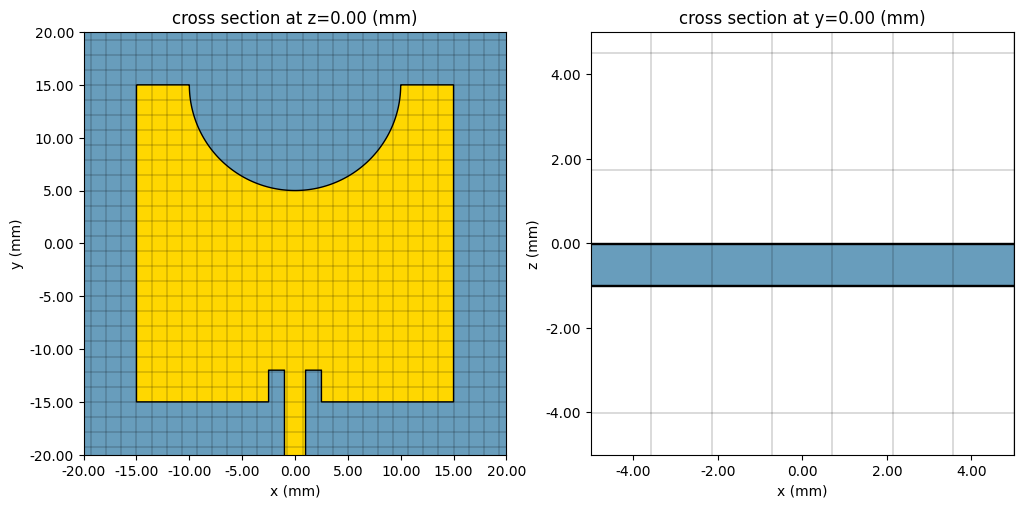

In [8]:
plot_sim_grid(sim)

## Basic Layer Refinement Specification

Let's create a basic [LayerRefinementSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LayerRefinementSpec.html) to refine mesh in layered structures where the structure is assumed to be uniform along the layer thickness axis. The layer refinement specification consists of the following elements:

1. The geometry of the layer, which is a [Box](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Box.html). It must be finite along the layer thickness axis, and can be finite or infinite along lateral axes.
2. The layer normal axis.
3. Mesh refinement specs for the cross-section of the layer.
4. Mesh refinement specs along the layer thickness axis.

The 1st and 2nd elements are needed for a minimal definition, while the default values for the 3rd and 4th elements are usually good enough. Let's define a layer refinement specification for the patch layer.

In [9]:
# 3 ways of defining the layer
# 1) from class initialization
layer_spec = td.LayerRefinementSpec(
    axis=2,  # z-axis
    center=patch_geometry.bounding_box.center,
    size=(td.inf, td.inf, patch_thickness),
)
# 2) from layer bounds
layer_spec = td.LayerRefinementSpec.from_layer_bounds(
    axis=2,  # z-axis
    bounds=(-patch_thickness / 2, patch_thickness / 2),
)
# 3) from structures in the same layer
layer_spec = td.LayerRefinementSpec.from_structures(
    axis=2,
    structures=[patch],
)

We update the simulation grid spec with the layer refinement spec.

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 2 WARNING messages.                            

{'Nx': 50,
 'Ny': 44,
 'Nz': 11,
 'grid_points': 24200,
 'min_grid_size': 703.2479150924228,
 'max_grid_size': 2743.999719619751,
 'computational_complexity': 34.4117621689921}


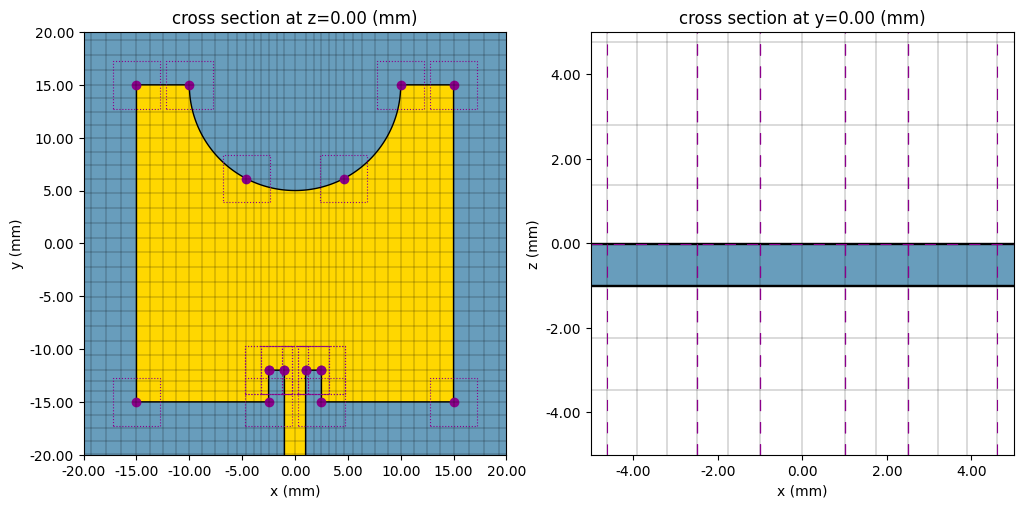

In [10]:
grid_spec_basic = grid_spec.updated_copy(layer_refinement_specs=[layer_spec])
sim_basic = sim.updated_copy(grid_spec=grid_spec_basic)

plot_sim_grid(sim_basic)

The top view (left figure) shows that all corners (magenta dots) are identified. Grid lines now pass through those corners. Mesh refinement structures (dotted squares) are also added around the corners. The front view (right figure) doesn't look much different from the default grid, as the default behavior is just to ensure that a grid line is passing through the lower boundary of the layer. Even though we don't add grids along the normal axis to resolve metal thickness, the simulation in most cases is accurate enough because of our subpixel averaging scheme (also known as conformal meshing).

## Advanced Layer Refinement Specification

Now let's discuss some more advanced refinement features:

### In-plane Mesh Refinement Around Corners

The mesh density around the corners is controlled by the variable `corner_refinement` in the `LayerRefinementSpec` object. One can define explicitly the refined grid size, or implicitly by defining refinement factor where the refined grid size will be the grid size in vacuum divided by the refinement factor. For more details, please refer to the [GridRefinement](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GridRefinement.html) doc. As an example, let's refine the mesh so that the grid size is 0.5 mm around the corners.

In [11]:
# approach 1: specify explicit grid size
corner_refinement = td.GridRefinement(dl=0.5 * mm)

# approach 2: specify refinement factor
grid_size_in_vacuum = wavelength / resolution
corner_refinement = td.GridRefinement(refinement_factor=grid_size_in_vacuum / (0.5 * mm))

# define layer refinement spec
layer_spec = td.LayerRefinementSpec.from_structures(
    axis=2,
    structures=[patch],
    corner_refinement=corner_refinement,
)

09:59:34 UTC WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 2 WARNING messages.                            

{'Nx': 93,
 'Ny': 65,
 'Nz': 11,
 'grid_points': 66495,
 'min_grid_size': 304.87187263863234,
 'max_grid_size': 2743.999719619751,
 'computational_complexity': 218.1080183766811}


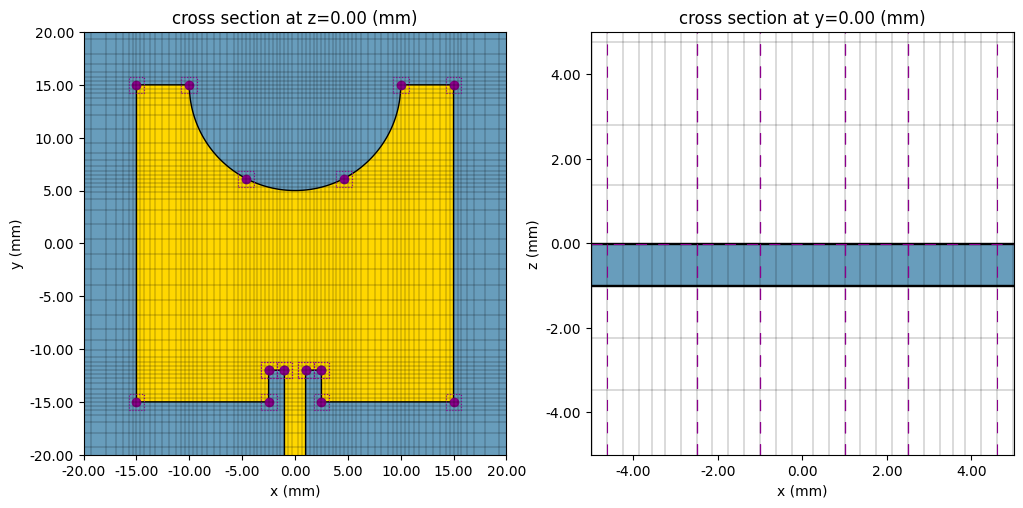

In [12]:
grid_spec_finer = grid_spec.updated_copy(layer_refinement_specs=[layer_spec])
sim_finer = sim.updated_copy(grid_spec=grid_spec_finer)

plot_sim_grid(sim_finer)

### Mesh Refinement Along Layer Thickness

In addition to the in-plane mesh refinement, very often we want to refine the mesh along the layer thickness axis. In the example above, we want to refine the substrate layer so that it is resolved by at least 2 grid cells. We don't need to detect corners in this layer, so we can simply set `corner_finder` to `None`.

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 1 WARNING message.                             

{'Nx': 93,
 'Ny': 65,
 'Nz': 17,
 'grid_points': 102765,
 'min_grid_size': 304.87187263863234,
 'max_grid_size': 2000.8862526868907,
 'computational_complexity': 337.0760284003253}


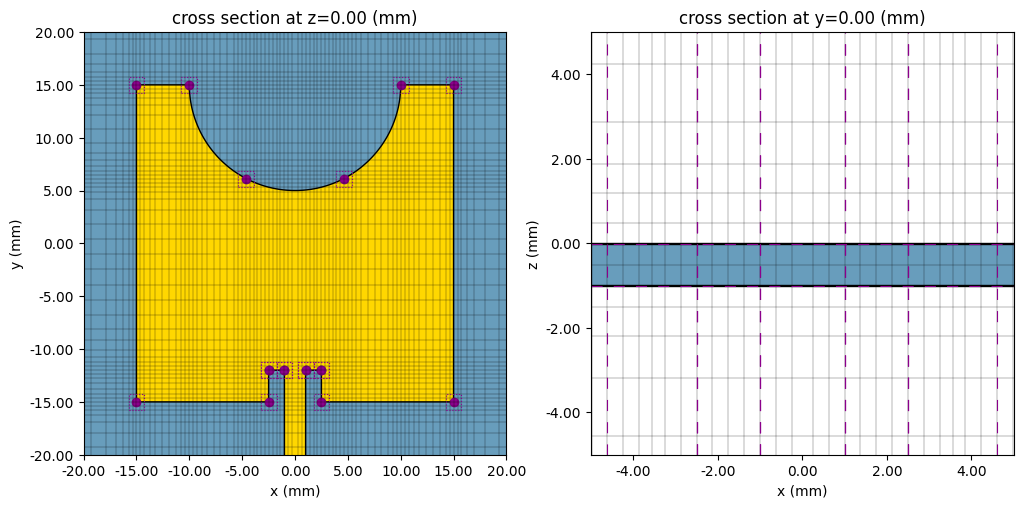

In [13]:
# define layer refinement spec for substrate layer
subs_layer_spec = td.LayerRefinementSpec.from_structures(
    axis=2,
    structures=[substrate],
    corner_finder=None,
    min_steps_along_axis=2,
)

grid_spec_subs = grid_spec.updated_copy(layer_refinement_specs=[subs_layer_spec, layer_spec])
sim_subs = sim.updated_copy(grid_spec=grid_spec_subs)

plot_sim_grid(sim_subs)

Similar to in-plane mesh refinement, we can also refine around the layer boundaries along the normal axis, which is defined by the `bounds_refinement` variable in the `LayerRefinementSpec` object. Additionally, we can specify whether to snap grid lines to the layer boundaries, which is controlled by the `bounds_snapping` variable.